In [14]:
import numpy as np
import pandas as pd

%run settings/plt_settings.ipynb
%run settings/db_connect.ipynb

# $P_L$

In [30]:
dis40 = sql(r"""select * from dis40 where len >= 40""")
dis40.head()

,len,dis,dis_random,dis_uniform
ac,,,,
A0A060X6Z0,489,True,True,False
A0A068FIK2,1033,True,True,False
A0A075F932,421,True,False,False
A0A078CGE6,1299,True,True,False
A0A086F3E3,192,False,True,False


In [27]:
def generate_PL(df, column):
    from functools import lru_cache
    
    df = pd.DataFrame(dis40[['len', column]])
   
    @lru_cache(maxsize=None)
    def _PL(L):
        eps = round(0.1*L)
        return df[ (df.len >= L-eps) & (df.len <= L+eps) ].mean()[column]
        
    _PL.df = df
    _PL.raw = df.groupby('len').mean()  # da bi kasnije mogao da se referisem na njega
    
    return _PL
  
PL = generate_PL(dis40, 'dis')
PL_random = generate_PL(dis40, 'dis_random')
PL_uniform = generate_PL(dis40, 'dis_uniform')

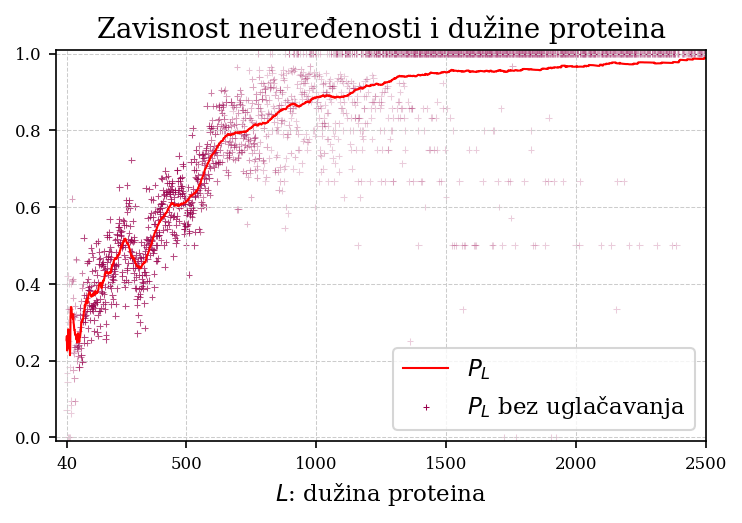

In [28]:
fig, ax = plt.subplots() 

xs = np.arange(40, 2500)
ys = np.array([PL(x) for x in xs])

ax.plot(xs, ys, 'r-', linewidth=1, label='$P_L$')

xs_count = PL.df.groupby('len').count().dis
xs_color = [(0.6,0,0.3, max(min(n/100,0.7),0.2) ) for n in xs_count]
ax.scatter( PL.raw.index,  PL.raw.dis, label='$P_L$ bez uglačavanja'
            , marker='+', color=xs_color, linewidth=0.5, s=10)

ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0, 2500)
ax.set_xticks([40]+list(range(0, 2501, 500))[1:])

ax.set_title('Zavisnost neuređenosti i dužine proteina')
ax.set_xlabel("$L$: dužina proteina")

leg =ax.legend()
leg.legendHandles[1].set_color((0.6,0,0.3))

plt.savefig('plots/PL_F.pdf', dpi=300)

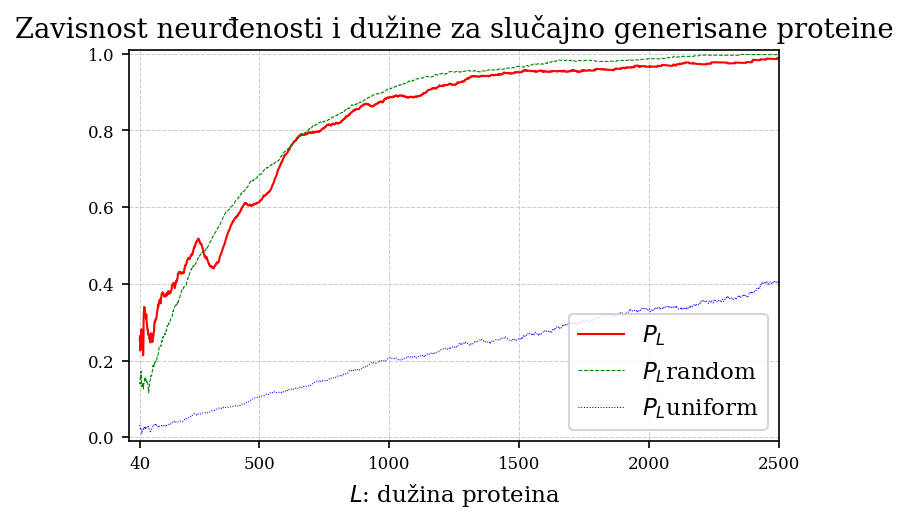

In [62]:
fig, ax = plt.subplots() 

xs = np.arange(40, 2500)
ys = np.array([PL(x) for x in xs])
ys_random = np.array([PL_random(x) for x in xs])
ys_uniform = np.array([PL_uniform(x) for x in xs])

plt.plot(xs, ys, 'r-', linewidth=1, label='$P_L$')
plt.plot(xs, ys_random, 'g--', linewidth=0.5, label='$P_L$random')
plt.plot(xs, ys_uniform, 'b:', linewidth=0.5, label='$P_L$uniform')

ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0, 2500)
ax.set_xticks([40]+list(range(0, 2501, 500))[1:])

ax.set_title('Zavisnost neurđenosti i dužine za slučajno generisane proteine')
ax.set_xlabel("$L$: dužina proteina")

plt.legend(loc='lower right' )

plt.savefig('plots/PL_F_cmp.pdf', dpi=300)

# Dis

In [179]:
Fj_kw_raw = sql(r"""
select kw, name
     , count(kw) n
     , avg(len) avg_len
     , avg(dis::int) avg_dis
     , array_agg(len) length_list
     
from dis40 join prot2kw on ac=prot
           join keywords on keywords.ac=prot2kw.kw

where true
  and category = 'KW-9992' -- Molecular function
  and len >=40             -- za svaki slucaj, valjda cu uklonti iz tabele dis40

group by (kw, name)
""")
Fj_kw_raw.head()

,name,n,avg_len,avg_dis,length_list
kw,,,,,
KW-0008,Acetylcholine receptor inhibiting toxin,12,70.750000,0.250000,"[109, 111, 64, 64, 58, 59, 62, 60, 64, 69, 60,..."
KW-0009,Actin-binding,837,974.918757,0.768220,"[730, 166, 492, 143, 490, 755, 821, 610, 1399,..."
KW-0010,Activator,2574,600.510101,0.878788,"[650, 50, 238, 931, 532, 579, 775, 1020, 1310,..."
KW-0012,Acyltransferase,867,531.583622,0.422145,"[1189, 289, 484, 511, 357, 433, 184, 278, 171,..."
KW-0022,Alpha-amylase inhibitor,3,166.333333,0.000000,"[146, 153, 200]"


In [151]:
%%cython -f
from libc.stdlib cimport rand, srand, RAND_MAX

srand(0);
  
cdef float random1():
    return rand()/float(RAND_MAX)

def calcYj(PL_list):
    cdef int i = 0
    cdef float l
    for PL_instance in PL_list:
        if random1() < PL_instance:
            i+=1
    return i/len(PL_list)

In [191]:
def calc_stat(Fj, PL):
    from tqdm import tqdm

    stat_info = []

    for index, row in tqdm(Fj.iterrows(), total=len(Fj), ):
        PL_list = [ PL(l) for l in row['length_list']]
        Yj_realisations = np.array( [calcYj(PL_list) for _ in range(1000)] )
        p = (Yj_realisations > row.avg_dis).mean()  # empirical


        Yj_mean = Yj_realisations.mean()
        Yj_std  = Yj_realisations.std() #or 0.0000001

        z = (row.avg_dis - Yj_mean) / Yj_std
        #pp = 1/2*(1 - math.erf(z/2))
        #print('go:', go, 'p:', p, mean, std, z, 'pp:', pp)   
        stat_info.append((index, p, z))

    stat_info = pd.DataFrame(stat_info, columns=['index', 'p', 'z']).set_index('index')
    return  pd.DataFrame(Fj[Fj.columns[:-1]]).join(stat_info)

In [197]:
Fj_kw_stat = calc_stat(Fj_kw_raw, PL_uniform)


100%|██████████| 186/186 [00:10<00:00, 17.86it/s]

In [198]:
(Fj_kw_stat.query('n>=20 and p<0.05 or p>0.95')
           .sort_values('z', ascending=False))

,name,n,avg_len,avg_dis,p,z
kw,,,,,,
KW-0238,DNA-binding,6518,546.531912,0.871126,0.000,203.787808
KW-0217,Developmental protein,3897,655.208622,0.859379,0.000,150.834894
KW-0010,Activator,2574,600.510101,0.878788,0.000,131.879725
KW-0808,Transferase,8846,631.948112,0.550305,0.000,126.760838
KW-0694,RNA-binding,2728,575.764296,0.763563,0.000,113.741700
KW-0678,Repressor,1988,589.294769,0.852113,0.000,106.784376
KW-0378,Hydrolase,7564,614.813194,0.514014,0.000,105.940254
KW-0687,Ribonucleoprotein,1886,272.285260,0.595970,0.000,99.061838
KW-0418,Kinase,3072,730.203776,0.708008,0.000,96.420729


****